# Basic RNA circuit simulation 



In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from bioreaction.simulation.basic_sim import convert_model

import jax
import numpy as np
import pandas as pd
import os
import sys
from functools import partial
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-paper')
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'gpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.common.setup import prepare_config, construct_circuit_from_cfg
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.evolution.evolver import load_mutations
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.common.testing.shared import five_circuits
from synbio_morpher.utils.results.analytics.timeseries import compute_sensitivity, compute_precision, calculate_adaptation

config = load_json_as_dict('../synbio_morpher/utils/common/testing/configs/simple_circuit.json')


In [63]:
def calculate_precision(output_diff, starting_states, signal_diff, signal_0) -> np.ndarray:
    denom = np.where(signal_0 != 0, signal_diff / signal_0, 1)
    numer = np.where((starting_states != 0).astype(int),
                      output_diff / starting_states, 1)
    precision = np.absolute(np.divide(
        numer, denom))
    return np.divide(1, precision)


def get_precision(signal_idx: int, starting_states, steady_states):
    if signal_idx is None:
        return None
    signal_0 = starting_states[signal_idx]
    signal_1 = steady_states[signal_idx]

    signal_diff = signal_1 - signal_0
    output_diff = steady_states - starting_states

    return calculate_precision(output_diff, starting_states, signal_diff, signal_0)


final, initial, signal_f, signal_i = (173.34004, 157.3838, 419.0314, 76.26714)
signal_diff = signal_f - signal_i
output_diff = final - initial
calculate_precision(output_diff, np.expand_dims(initial, axis=0), signal_diff, signal_i)
denom = np.where(signal_i != 0, signal_diff / signal_i, 1)

numer = np.where((np.expand_dims(initial, axis=0) != 0).astype(int),
                    output_diff / initial, 1)


In [64]:
def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else: # unbound RNA -> bound RNA
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


def make_params(model, scale_rates=True):
    sim_model = convert_model(model)

    if scale_rates:
        m = np.max([sim_model.forward_rates.max(), sim_model.reverse_rates.max()])
    else:
        m = 1
    inputs = sim_model.inputs
    outputs = sim_model.outputs
    forward_rates = sim_model.forward_rates/m
    reverse_rates = sim_model.reverse_rates/m
    return inputs, outputs, forward_rates, reverse_rates, m

Use the 5 tester circuits :)

In [65]:
config = prepare_config(config)
config['include_prod_deg'] = False
config['simulation']['use_initial_to_add_signal'] = False
config['simulation']['use_rate_scaling'] = True
config['simulation']['device'] = 'gpu'
config['simulation']['t1'] = 200
config['simulation']['tmax'] = 400
config['simulation']['interaction_factor'] = 1
config['signal']['function_kwargs']['target'] = 2

q = 1
p = 1
config['molecular_params_factor'] = p
config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * q
config['molecular_params']['creation_rate' + '_per_molecule'] = config['molecular_params']['creation_rate' + '_per_molecule'] * q
# config['simulation']['dt0'] = 0.1
# config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * p
# config['molecular_params']['degradation_rate'] = config['molecular_params']['degradation_rate'] * p

In [66]:
circuits, config, result_writer = five_circuits(config)


In [67]:
config['interaction_simulator']['simulator_kwargs']['threads'] = 8

In [68]:
def load_circuit(top_dir, circuit_name, config):
    dp = os.path.join(top_dir, 'circuits', circuit_name + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join(top_dir, 'binding_rates_dissociation', circuit_name + '_' + 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join(top_dir, 'eqconstants', circuit_name + '_' + 'eqconstants' + '.csv'),
                    'energies': os.path.join(top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}

    return construct_circuit_from_cfg({
        'data_path': dp,
        'interactions': interactions
    }, config)


# tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#              circuit_name='toy_mRNA_circuit_1844', config=config)


# tester_circuits = []
# for name in ['toy_mRNA_circuit_21566', 'toy_mRNA_circuit_24706', 'toy_mRNA_circuit_19768', 'toy_mRNA_circuit_2983', 'toy_mRNA_circuit_22658']:
#     fn = os.path.join('..', 'data/ensemble_mutation_effect_analysis/2023_04_11_192013/mutation_effect_on_interactions_signal', name, 'mutations.csv')
#     tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#                                         circuit_name=name, config=config)
#     tester_circuit = load_mutations(tester_circuit, fn)
#     tester_circuits.append(tester_circuit)

# config['interactions'] = {}
# config['interactions'] = None
# tester_circuit = construct_circuit_from_cfg(
#     {'data_path': '../tester.fasta'}, config)
# [circuits.append(tester_circuit) for tester_circuit in tester_circuits]


# Load fake circuits

In [69]:
def load_fake_circuit(eqconstants):
    pdir = '../'
    top_dir = 'data/ensemble_mutation_effect_analysis/2024_11_09_164634/generate_species_templates'
    circuit_name = 'toy_mRNA_circuit_0'
    some_circuit = os.path.join(pdir, top_dir, 'circuits', circuit_name + '.fasta')

    k_a = config['molecular_params']['association_binding_rate' + '_per_molecule']

    binding_rates_dissociation = eqconstant_to_rates(eqconstants, k_a)[1]

    labels = ['RNA_0', 'RNA_1', 'RNA_2']
    pd.DataFrame(eqconstants, columns=labels, index=labels).to_csv(
        'eqconstants.csv', index=None)
    pd.DataFrame(binding_rates_dissociation, columns=labels, index=labels).to_csv('binding_rates_dissociation.csv', index=None)

    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join(pdir, 'explanations', 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join(pdir, 'explanations', 'eqconstants' + '.csv'),
                    'energies': os.path.join(pdir, top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(pdir, top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}
    return construct_circuit_from_cfg({
        'data_path': some_circuit,
        'interactions': interactions
    }, config)


eqconstants_4337 = np.array([[1e2, 1e2, 5e0],
                             [1e2, 1e-02, 1e2],
                             [5e0, 1e2, 1e-02]])

# tester_circuit = load_fake_circuit(eqconstants_4337)
tester_circuit1 = load_fake_circuit(np.ones((3,3)))
tester_circuit1.name = 'K_1'
tester_circuit2 = load_fake_circuit(np.ones((3,3)) * 0.5)
tester_circuit2.name = 'K_05'
# tester_circuit2 = load_fake_circuit(np.ones((3,3)) * 0)
# tester_circuit2.name = 'K_0'

circuits.append(tester_circuit1)
circuits.append(tester_circuit2)



interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/binding_rates_dissociation.csv WARNING
interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/eqconstants.csv WARNING
interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/binding_rates_dissociation.csv WARNING
interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/eqconstants.csv WARNING


### Throw in some more fake circuits

In [70]:
def load_fake_circuit2(energies):
    pdir = '../'
    top_dir = 'data/ensemble_mutation_effect_analysis/2024_11_09_164634/generate_species_templates'
    circuit_name = 'toy_mRNA_circuit_0'
    some_circuit = os.path.join(pdir, top_dir, 'circuits', circuit_name + '.fasta')
    N0 = config['molecular_params']['starting_copynumbers'] 
    k_a = config['molecular_params']['association_binding_rate' + '_per_molecule']

    eqconstants = equilibrium_constant_reparameterisation(energies, initial=N0)
    binding_rates_dissociation = eqconstant_to_rates(eqconstants, k_a)[1]

    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'] * np.ones((3,3)),
                    'binding_rates_dissociation': binding_rates_dissociation,
                    'eqconstants': eqconstants,
                    'energies': energies,
                    'binding_sites': None}
    return construct_circuit_from_cfg({
        'data_path': some_circuit,
        'interactions_loaded': interactions,
        'interactions': None
    }, config)

n_extra_fakes = 30
energies = np.random.rand(n_extra_fakes, 3, 3)
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
for i, e in enumerate(energies):
    e[np.tril_indices(3)] = e.T[np.tril_indices(3)]
    energies[i] = e
    circuits.append(load_fake_circuit2(e))
    circuits[-1].name = f'rand_{i}'

array([[ -2.92264472,  -9.29223697, -20.81188141],
       [ -9.29223697, -13.75349188, -22.95710708],
       [-20.81188141, -22.95710708,  -6.0319834 ]])

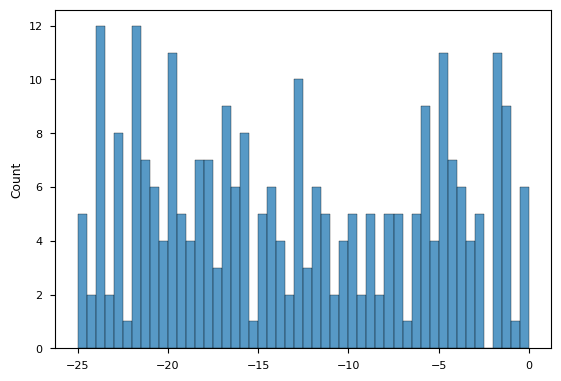

In [71]:
sns.histplot(energies.flatten(), bins=50)
# sns.histplot((eqconstant_to_rates(eqconstants, k_a)[1]).flatten(), bins=50)
e

<Axes: ylabel='Count'>

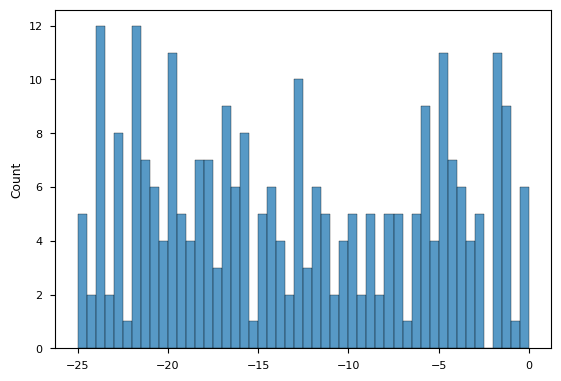

In [72]:
sns.histplot(np.concat([c.interactions.energies for c in circuits[-n_extra_fakes:]]).flatten(), bins=50)


In [73]:
config['molecular_params']['association_binding_rate' + '_per_molecule']

np.float64(0.00150958097)

In [74]:
# for c in circuits:
#     c.reset_to_initial_state()

# Run interaction simulation

In [75]:
circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
circuits = circuit_modeller.batch_circuits(
    circuits=circuits, methods={"compute_interactions": {}},
    batch_size=config['simulation']['batch_size'])
i = -1


circuit_manager.py:batch_circuits():600: 	From 37 circuits, a total of 37 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():607: 		Starting new round of viable circuits (0 - 37 / 37) WARNING
circuit_manager.py:batch_circuits():627: 		Making subcircuits 0 - 37 took 4.3e-05s WARNING
circuit_manager.py:batch_circuits():633: 	Batching 0 - 100 circuits (out of 0 - 37 (total: 37)) (Circuits: 0 - 37 of 37) WARNING
circuit_manager.py:run_batch():665: 		Running 37 Subcircuits - 0_weak: compute_interactions WARNING
circuit_manager.py:run_batch():701: 		Method compute_interactions took 0.121366s WARNING
circuit_manager.py:batch_circuits():647: Single batch: 0:00:00.122948 
Projected time: 0.12294800000000002s 
Total time: 0:00:00.122962 WARNING


'loaded'

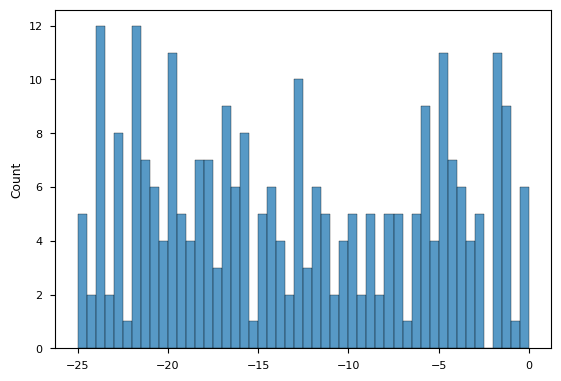

In [76]:
sns.histplot(np.concat([c.interactions.energies for c in circuits[-n_extra_fakes:]]).flatten(), bins=50)

circuits[-1].interactions_state

In [77]:
circuits[i].interactions.binding_rates_dissociation

Array([[8.6858345e+01, 5.3184921e-01, 5.2899832e-05],
       [5.3184921e-01, 1.4989589e-02, 9.5088153e-06],
       [5.2899832e-05, 9.5088153e-06, 7.2196574e+00]], dtype=float32)

In [78]:
circuits[i].interactions.binding_rates_association

array([[0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958]])

In [79]:
config['molecular_params']['creation_rate']

2.35

In [80]:
config['molecular_params']['degradation_rate']


0.01175

# Run dynamic simulation

In [81]:
circuits = circuit_modeller.batch_circuits(
    circuits=circuits, 
    batch_size=config['simulation']['batch_size'],
    methods={
        # "compute_interactions": {},
        "init_circuits": {'batch': True},
        'simulate_signal_batch': {'ref_circuit': None,
                                  'batch': config['simulation']['use_batch_mutations']},
        'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
                          'no_numerical': False} #config['experiment']['no_numerical']}
    }
)

circuit_manager.py:batch_circuits():600: 	From 37 circuits, a total of 37 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():607: 		Starting new round of viable circuits (0 - 37 / 37) WARNING
circuit_manager.py:batch_circuits():627: 		Making subcircuits 0 - 37 took 4.4e-05s WARNING
circuit_manager.py:batch_circuits():633: 	Batching 0 - 100 circuits (out of 0 - 37 (total: 37)) (Circuits: 0 - 37 of 37) WARNING
circuit_manager.py:run_batch():665: 		Running 37 Subcircuits - 0_weak: init_circuits WARNING


Steady states:  200  iterations.  5  left to steady out.  0:00:59.890302


circuit_manager.py:run_batch():701: 		Method init_circuits took 120.367534s WARNING
circuit_manager.py:run_batch():665: 		Running 37 Subcircuits - 0_weak: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():515: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:02:00.164704


circuit_manager.py:simulate_signal_batch():356: 		Simulating signal took 13.89944s WARNING


Done:  0:00:13.884703


circuit_manager.py:simulate_signal_batch():414: 		Calculating analytics took 1.128503s WARNING
circuit_manager.py:run_batch():701: 		Method simulate_signal_batch took 15.308816s WARNING
circuit_manager.py:run_batch():665: 		Running 37 Subcircuits - 0_weak: write_results WARNING
circuit_manager.py:run_batch():701: 		Method write_results took 6.57749s WARNING
circuit_manager.py:batch_circuits():647: Single batch: 0:02:22.257883 
Projected time: 142.257883s 
Total time: 0:02:22.257892 WARNING


# Plot results

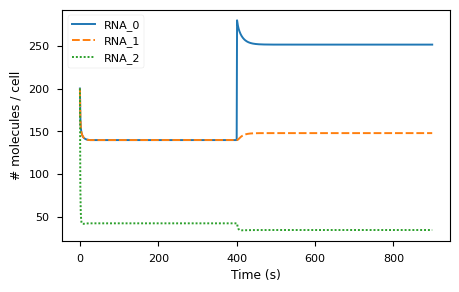

In [82]:
chosen_circuit = circuits[1]
data_fn_ste = os.path.join(result_writer.write_dir, chosen_circuit.name, 'steady_states_data.csv')
data_fn_sig = os.path.join(result_writer.write_dir, chosen_circuit.name, 'signal_data.csv')
data = pd.concat([
    pd.read_csv(data_fn_ste, names=sorted([s.name for s in chosen_circuit.model.species])),
    pd.read_csv(data_fn_sig, names=sorted([s.name for s in chosen_circuit.model.species]))
]).reset_index()

plt.figure(figsize=(5,3))
sns.lineplot(data[sorted([s.name for s in chosen_circuit.get_input_species()])])
plt.ylabel('# molecules / cell')
plt.xlabel('Time (s)')
plt.savefig('output/circ4.svg')


In [83]:
all_df = pd.DataFrame()
for c in circuits:
    analytics_fn_sig = os.path.join(result_writer.write_dir, c.name, 'report_signal.json')
    df = pd.DataFrame().from_dict(load_json_as_dict(analytics_fn_sig))
    df = df.apply(pd.to_numeric, errors='coerce')
    df['sample_name'] = [s.name for s in c.model.species]
    df['name'] = c.name
    df = df[['name'] + list(df.columns[:-1])]
    all_df = pd.concat([all_df, df])
all_df

,name,fold_change,initial_steady_states,max_amount,min_amount,overshoot,RMSE,steady_states,response_time_wrt_species-6,precision_wrt_species-6,sensitivity_wrt_species-6,sample_name
0,0_weak,3.989330,6.691297e-02,2.669380e-01,6.691297e-02,0.000000e+00,0.0,2.669380e-01,0.000000,0.334523,2.989330,"('RNA_0', 'RNA_0')"
1,0_weak,1.996667,6.691297e-02,1.336035e-01,6.691297e-02,5.662441e-07,0.0,1.336029e-01,0.000000,1.003344,0.996676,"('RNA_0', 'RNA_1')"
2,0_weak,1.996667,6.691297e-02,1.336035e-01,6.691297e-02,5.662441e-07,0.0,1.336029e-01,0.000000,1.003344,0.996676,"('RNA_0', 'RNA_2')"
3,0_weak,0.999336,6.691297e-02,6.691297e-02,6.686856e-02,0.000000e+00,0.0,6.686856e-02,inf,1506.610800,0.000664,"('RNA_1', 'RNA_1')"
4,0_weak,0.999336,6.691297e-02,6.691297e-02,6.686856e-02,0.000000e+00,0.0,6.686856e-02,inf,1506.610800,0.000664,"('RNA_1', 'RNA_2')"
...,...,...,...,...,...,...,...,...,...,...,...,...
4,rand_29,1.001175,7.200078e+01,7.208539e+01,7.200078e+01,0.000000e+00,0.0,7.208539e+01,25.651304,850.972530,0.001175,"('RNA_1', 'RNA_2')"
5,rand_29,0.345715,6.247004e-07,6.247004e-07,2.159685e-07,1.278977e-13,0.0,2.159686e-07,96.593185,1.528387,0.654285,"('RNA_2', 'RNA_2')"
6,rand_29,1.936925,6.780807e+01,1.356161e+02,6.780807e+01,4.277008e+00,0.0,1.313391e+02,16.833668,1.067322,1.000000,RNA_0
7,rand_29,0.982703,2.241787e+01,2.241787e+01,2.026700e+01,1.763111e+00,0.0,2.203011e+01,42.885770,57.814037,0.095944,RNA_1


In [84]:
all_df['adaptability'] = calculate_adaptation(all_df['sensitivity_wrt_species-6'].to_numpy(), all_df['precision_wrt_species-6'].to_numpy())
# all_df['adaptability2'] = calculate_adaptation(all_df['sensitivity2_wrt_species-6'].to_numpy(), all_df['precision_wrt_species-6'].to_numpy())

<Axes: ylabel='Count'>

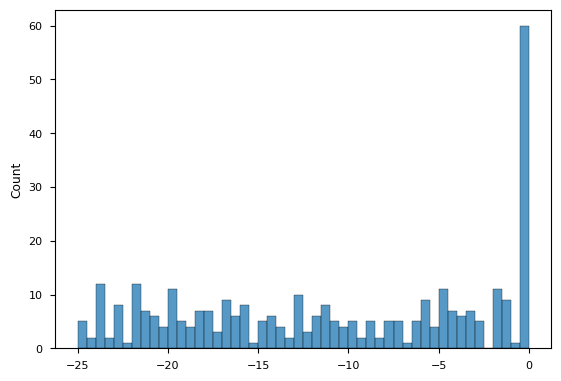

In [85]:
sns.histplot(np.concat([c.interactions.energies.flatten() for c in circuits]), bins=50)

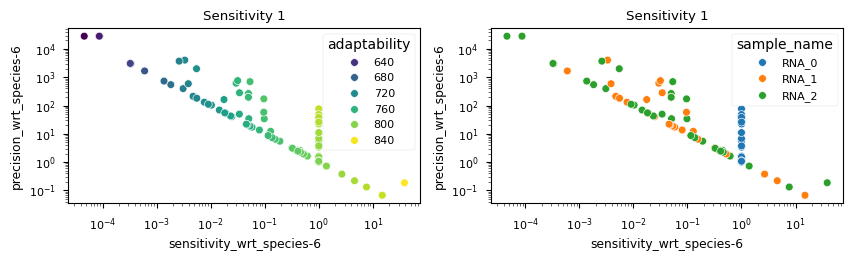

In [86]:
species_unbound = [s.name for s in circuits[0].get_input_species()]

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(2,2,1)
sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='adaptability', palette='viridis')
plt.xscale('log')
plt.yscale('log')
plt.title('Sensitivity 1')

ax = plt.subplot(2,2,2)
sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sample_name')
plt.xscale('log')
plt.yscale('log')
plt.title('Sensitivity 1')

if 'sensitivity2_wrt_species-6' in all_df.columns:
    ax = plt.subplot(2,2,3)
    sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivity2_wrt_species-6', y='precision_wrt_species-6', hue='adaptability2', palette='viridis')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Sensitivity 2')

    ax = plt.subplot(2,2,2)
    sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivit2y_wrt_species-6', y='precision_wrt_species-6', hue='sample_name')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Sensitivity 2')

# Visualise most adaptable circuits

In [87]:
names_circuits_adapting = all_df[all_df['sample_name'].isin(species_unbound[1:])].sort_values('adaptability', ascending=False).iloc[:5]['name'].to_list()

circuits_adapting = [c for c in circuits if c.name in names_circuits_adapting]

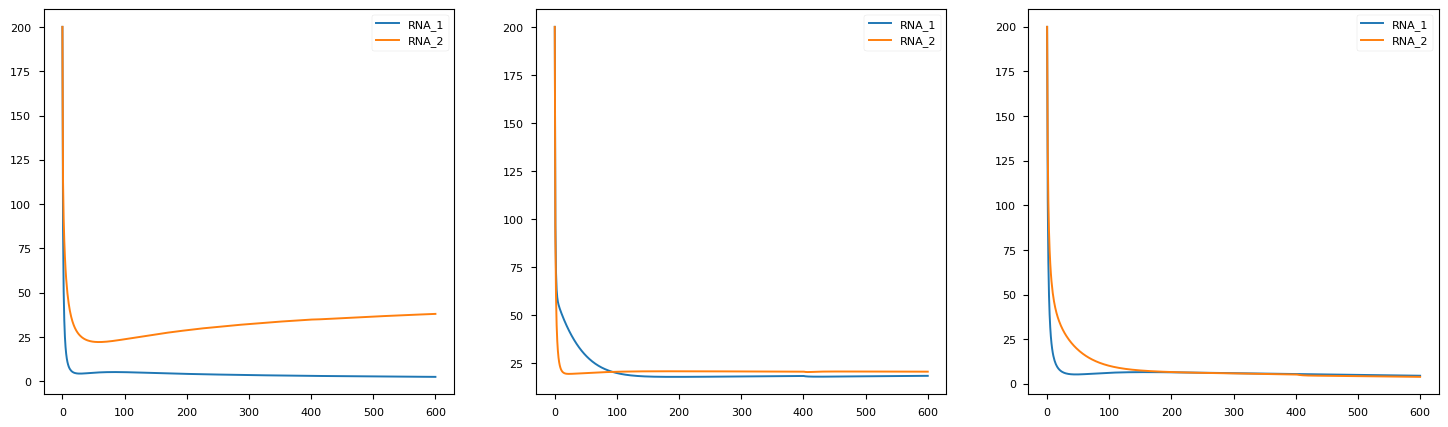

In [88]:
fig = plt.figure(figsize=(6*len(circuits_adapting),5))
for i, c in enumerate(circuits_adapting):
    r0 = c.result_collector.get_result('steady_states').vis_kwargs
    r1 = c.result_collector.get_result('signal').vis_kwargs
    ts = np.concat([r0['t'], r1['t'] + r0['t'][-1]])
    y = np.concat([r0['data'].T, r1['data'].T])
    
    ax = plt.subplot(1, len(circuits_adapting), i+1)
    plt.plot(ts, y[:, -2:])
    plt.legend(r0['legend'][-2:])